In [1]:
import glob
import os
import psutil
import datetime
from random import sample

from ipywidgets import IntProgress
from IPython.display import display, HTML

import girder_client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torchmetrics
from pytorch_unet import UNet_rect_kernels

In [2]:
this_notebook_name = "PyTorchSagittalSpineSegmentationTest-RectangularKernels"

# Update this folder name for your computer

train_timestamp = "2021-08-05_16-21-43"
local_data_folder = r"/home/nick/dev/SaggitalSpineSegmentation_Data"

overwrite_existing_data_files = False

# All results and output will be archived with this timestamp

# Evaluation parameters

num_classes=2
acceptable_margin_mm = 1.0
mm_per_pixel = 1.0

roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]

limit_rounds = 0

# Uncomment for faster debugging
# roc_thresholds = [0.8, 0.6, 0.4, 0.2, 0.1, 0.01]
# limit_rounds = 2

In [3]:
device = 'cpu'

In [4]:
# Use cuda GPU if available

# device_name = " "
# if torch.cuda.is_available():
#     device_name = torch.cuda.get_device_name(torch.cuda.current_device())
# else:
#     device_name = 'bCPU'
    
# print('Using device:', device_name)

# device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
testing_ultrasound_filename = "ultrasound-test.npy"
testing_ultrasound_id = "5daa85edd9e6a3be02d012e7"
testing_segmentation_filename = "segmentation-test.npy"
testing_segmentation_id = "5daa85e7d9e6a3be02d012e4"

# Default subfolders of main project data folder

data_arrays_folder      = "DataArrays"
notebooks_save_folder   = "SavedNotebooks"
models_folder           = "SavedModels"
results_save_folder     = "SavedResults"
test_predictions_folder = "PredictionsTest"

data_arrays_fullpath      = os.path.join(local_data_folder, data_arrays_folder)
notebooks_save_fullpath   = os.path.join(local_data_folder, notebooks_save_folder)
models_fullpath           = os.path.join(local_data_folder, models_folder)
results_save_fullpath     = os.path.join(local_data_folder, results_save_folder)
test_predictions_fullpath = os.path.join(local_data_folder, test_predictions_folder)

if not os.path.exists(data_arrays_fullpath):
    os.makedirs(data_arrays_fullpath)
    print("Created folder: {}".format(data_arrays_fullpath))

if not os.path.exists(notebooks_save_fullpath):
    os.makedirs(notebooks_save_fullpath)
    print("Created folder: {}".format(notebooks_save_fullpath))

if not os.path.exists(models_fullpath):
    raise FileNotFoundError(models_fullpath)

if not os.path.exists(results_save_fullpath):
    os.makedirs(results_save_fullpath)
    print("Created folder: {}".format(results_save_fullpath))

if not os.path.exists(test_predictions_fullpath):
    os.makedirs(test_predictions_fullpath)
    print("Created folder: {}".format(test_predictions_fullpath))

In [6]:
# Download data from Girder

time_download_start = datetime.datetime.now()

print("Downloading testing files ...")

# Preparing progress bar

girder_api_url = "https://pocus.cs.queensu.ca/api/v1"
gclient = girder_client.GirderClient(apiUrl=girder_api_url)

test_ultrasound_fullname = os.path.join(data_arrays_fullpath, testing_ultrasound_filename)
if not os.path.exists(test_ultrasound_fullname):
    print("Downloading {}...".format(test_ultrasound_fullname))
    gclient.downloadFile(testing_ultrasound_id, test_ultrasound_fullname)

test_segmentation_fullname = os.path.join(data_arrays_fullpath, testing_segmentation_filename)
if not os.path.exists(test_segmentation_fullname) or overwrite_existing_data_files:
    print("Downloading {}...".format(test_segmentation_fullname))
    gclient.downloadFile(testing_segmentation_id, test_segmentation_fullname)
    
time_download_stop = datetime.datetime.now()
print("\nTotal download time: {}".format(time_download_stop - time_download_start))


Total download time: 0:00:00.000572


In [7]:
# Load numpy data
# convert ultrasound array to torch.tensor channels first
# Keep segmentation in numpy/TF format

time_start = datetime.datetime.now()

test_ultrasound_fullname = os.path.join(data_arrays_fullpath, testing_ultrasound_filename)
test_ultrasound_array = np.load(test_ultrasound_fullname)
test_ultrasound_array = torch.Tensor(test_ultrasound_array).permute(0,3,1,2).float().to(device)

test_segmentation_fullname = os.path.join(data_arrays_fullpath, testing_segmentation_filename)
test_segmentation_array = np.load(test_segmentation_fullname)
test_segmentation_array = torch.Tensor(test_segmentation_array).squeeze(3).long().to(device)

time_stop = datetime.datetime.now()
print("\nTotal time to load from files: {}".format(time_stop - time_start))


Total time to load from files: 0:00:00.083761


In [8]:
print(test_ultrasound_array.size(), test_segmentation_array.size())

torch.Size([1892, 1, 128, 128]) torch.Size([1892, 128, 128])


In [9]:
filename_pattern = "*" + train_timestamp + "*"
search_string = os.path.join(models_fullpath, filename_pattern)
print("Searching for models by {}".format(search_string))
model_file_list = sorted(glob.glob(search_string))

num_models = len(model_file_list)
print("Found {} model(s): ".format(num_models))
print(model_file_list)

if limit_rounds > 0:
    num_rounds = min(num_models, limit_rounds)
else:
    num_rounds = num_models

Searching for models by /home/nick/dev/SaggitalSpineSegmentation_Data/SavedModels/*2021-08-05_16-21-43*
Found 8 model(s): 
['/home/nick/dev/SaggitalSpineSegmentation_Data/SavedModels/PyTorchSagittalSpineSegmentationStudy-RectangularKernels_model-0_2021-08-05_16-21-43.msd', '/home/nick/dev/SaggitalSpineSegmentation_Data/SavedModels/PyTorchSagittalSpineSegmentationStudy-RectangularKernels_model-1_2021-08-05_16-21-43.msd', '/home/nick/dev/SaggitalSpineSegmentation_Data/SavedModels/PyTorchSagittalSpineSegmentationStudy-RectangularKernels_model-2_2021-08-05_16-21-43.msd', '/home/nick/dev/SaggitalSpineSegmentation_Data/SavedModels/PyTorchSagittalSpineSegmentationStudy-RectangularKernels_model-3_2021-08-05_16-21-43.msd', '/home/nick/dev/SaggitalSpineSegmentation_Data/SavedModels/PyTorchSagittalSpineSegmentationStudy-RectangularKernels_model-4_2021-08-05_16-21-43.msd', '/home/nick/dev/SaggitalSpineSegmentation_Data/SavedModels/PyTorchSagittalSpineSegmentationStudy-RectangularKernels_model-5_20

In [10]:
# define metrics from module torchmetrics
# our model will output multi class spatial data with logits
# so need softmax on model output

softmax = torch.nn.Softmax(dim=1).to(device)
dice = torchmetrics.F1(num_classes=num_classes, average='weighted', mdmc_average='global').to(device)
precision = torchmetrics.Precision(num_classes=num_classes, mdmc_average='global').to(device)
auroc = torchmetrics.AUROC(num_classes=num_classes).to(device)

/home/nick/anaconda3/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:37: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [11]:
# Main loop, test all models and save test results

time_sequence_start = datetime.datetime.now()

print("Using timestamp to find files: {}".format(train_timestamp))
print("Saving test predictions in:    {}".format(test_predictions_fullpath))

test_dices           = np.zeros(num_models)
test_precisions      = np.zeros(num_models)
test_aurocs          = np.zeros(num_models)

for i in range(num_models):
    time_round_start = datetime.datetime.now()
        
    model = UNet_rect_kernels(128,2).eval().to(device)
        
    print("Testing model: {}".format(model_file_list[i]))
    model.load_state_dict(torch.load(model_file_list[i]))
    
    with torch.no_grad():
        test_prediction = model(test_ultrasound_array)
        test_prediction = softmax(test_prediction)
    
        
    test_prediction_filename = train_timestamp + "_prediction_test.npy"
    test_prediction_fullname = os.path.join(test_predictions_fullpath, test_prediction_filename)
    
    # save npy version of tensor
    test_prediction_np = test_prediction.permute((0,2,3,1)).detach().numpy()
    np.save(test_prediction_fullname, test_prediction_np)        
    
    # Test results
    
    with torch.no_grad():
        print("computing dice: {}".format(datetime.datetime.now() - time_round_start))
        test_dices[i] = dice(test_prediction, test_segmentation_array)
        print("computing precision: {}".format(datetime.datetime.now() - time_round_start))
        test_precisions[i] = precision(test_prediction, test_segmentation_array)
        print("computing auroc: {}".format(datetime.datetime.now() - time_round_start))
        test_aurocs[i] = auroc(test_prediction, test_segmentation_array)
        
    print("Testing round time: {}".format(datetime.datetime.now() - time_round_start))

time_sequence_stop = datetime.datetime.now()

print("\nTotal testing time:   {}".format(time_sequence_stop - time_sequence_start))

Using timestamp to find files: 2021-08-05_16-21-43
Saving test predictions in:    /home/nick/dev/SaggitalSpineSegmentation_Data/PredictionsTest
Testing model: /home/nick/dev/SaggitalSpineSegmentation_Data/SavedModels/PyTorchSagittalSpineSegmentationStudy-RectangularKernels_model-0_2021-08-05_16-21-43.msd
ram percent5: 16.8
predicting on test data
ram percent6: 17.3
computing dice: 0:00:10.143912
computing precision: 0:02:02.112616
computing auroc: 0:03:54.713780
Testing round time: 0:05:49.106961
dices:  [0.99530673 0.         0.         0.         0.         0.
 0.         0.        ]
precisions:  [0.99486065 0.         0.         0.         0.         0.
 0.         0.        ]
aurocs:  [0.96044582 0.         0.         0.         0.         0.
 0.         0.        ]
Testing model: /home/nick/dev/SaggitalSpineSegmentation_Data/SavedModels/PyTorchSagittalSpineSegmentationStudy-RectangularKernels_model-1_2021-08-05_16-21-43.msd
ram percent5: 17.8
predicting on test data
ram percent6: 

In [15]:
# model = UNet_rect_kernels(128,2).eval().to(device)

# print("Testing model: {}".format(model_file_list[7]))
# model.load_state_dict(torch.load(model_file_list[7]))

# with torch.no_grad():
#     test_prediction = model(test_ultrasound_array)
#     test_prediction = softmax(test_prediction)

Testing model: /home/nick/dev/SaggitalSpineSegmentation_Data/SavedModels/PyTorchSagittalSpineSegmentationStudy-RectangularKernels_model-7_2021-08-05_16-21-43.msd


In [19]:
# Arrange results in tables

metric_labels = [
    "AUROC",
    "dice",
    "precision"
]

results_labels = []

for label in metric_labels:
    results_labels.append("Test " + label)

results_df = pd.DataFrame(columns = results_labels)

for i in range(num_rounds):
    results_df.loc[i] = [
        test_aurocs[i],
        test_dices[i],
        test_precisions[i],
    ]

print("PyTorch UNet with rectangular kernels")
display(results_df)

print("\nAverages")

results_means_df = results_df.mean()
display(results_means_df)

PyTorch UNet with rectangular kernels


,Test AUROC,Test dice,Test precision
0,0.960446,0.995307,0.994861
1,0.952216,0.996104,0.996614
2,0.966415,0.995385,0.994980
3,0.965315,0.995901,0.996056
4,0.957518,0.995965,0.996098
5,0.967646,0.995250,0.994600
6,0.978508,0.995674,0.995361
7,0.946737,0.995181,0.994598



Averages


Test AUROC        0.961850
Test dice         0.995596
Test precision    0.995396
dtype: float64

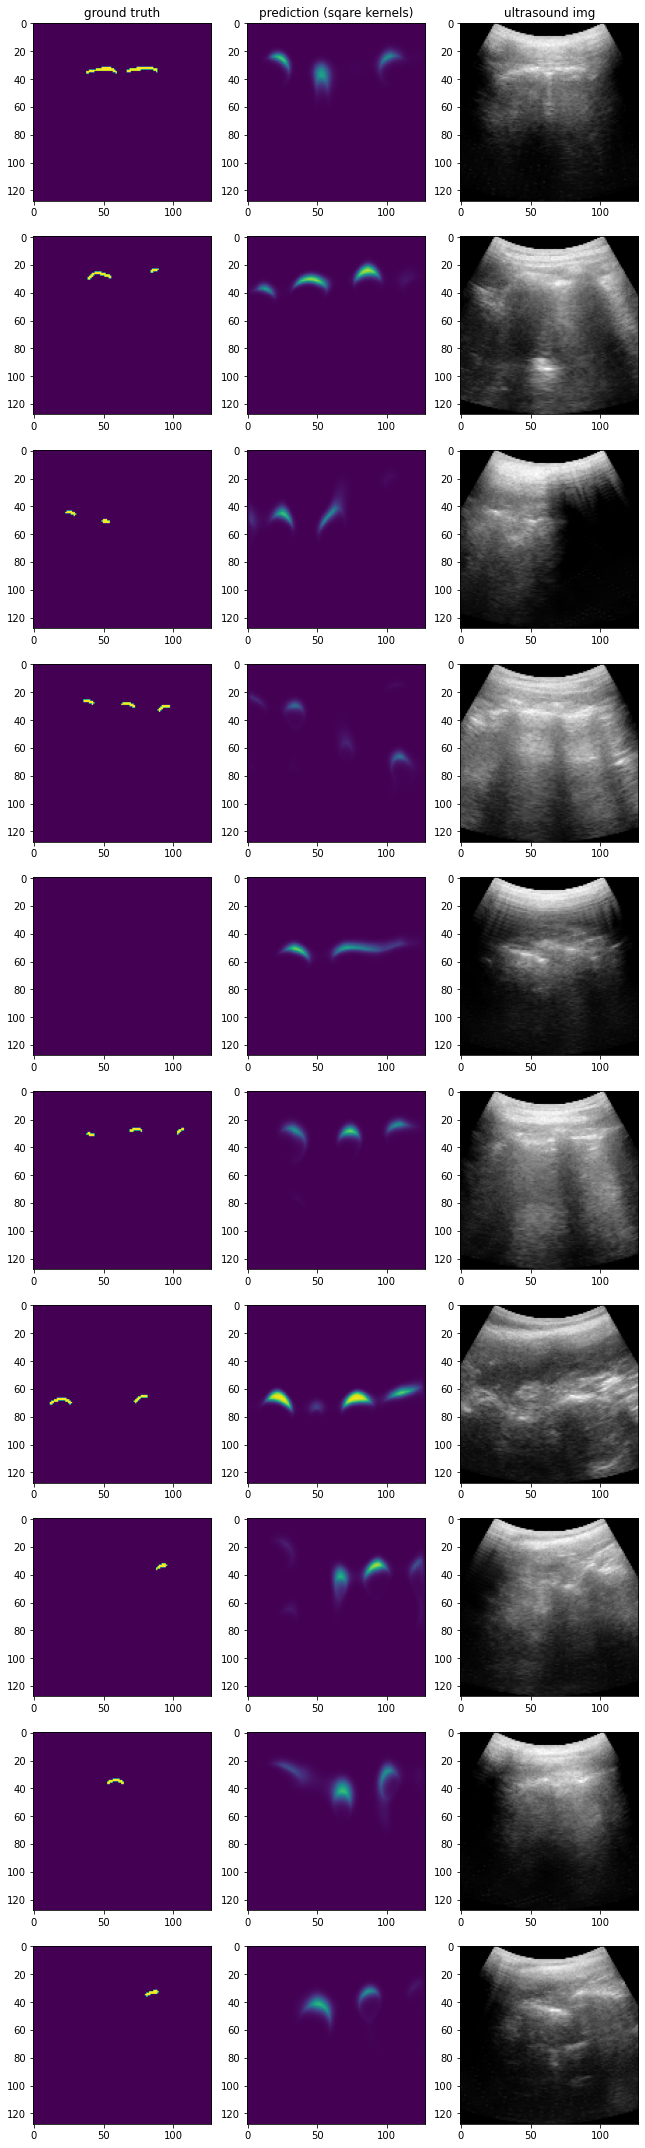

In [28]:
# View some segmentations

# print(test_segmentation_array.size())
# print(test_ultrasound_array.size())
# print(test_prediction.size())

num_rows = 10
np.random.seed(1)
indices = test_prediction.size(0)*np.random.rand(num_rows)

fig, axs = plt.subplots(num_rows,3)
fig.set_size_inches(9,3*num_rows)

for i in range(num_rows):
    idx = int(indices[i])
    
    img_np = test_ultrasound_array[idx].squeeze(0).detach().numpy()
    img_np = np.flip(img_np, axis=0)
    gt_np = test_segmentation_array[idx].detach().numpy()
    gt_np = np.flip(gt_np, axis=0)
    pred_sm_np = test_prediction[idx][1,:,:].squeeze(0).detach().numpy()
    pred_sm_np = np.flip(pred_sm_np, axis=0)
    
    axs[i,0].imshow(gt_np)
    if i == 0:
        axs[i,0].set_title("ground truth")
    axs[i,1].imshow(pred_sm_np, vmin=0., vmax=1.)
    if i == 0:
        axs[i,1].set_title("prediction (sqare kernels)")
    axs[i,2].imshow(img_np, cmap='gray')
    if i == 0:
        axs[i,2].set_title("ultrasound img")

plt.tight_layout()

plt.savefig('.rectkernelpreds.png')

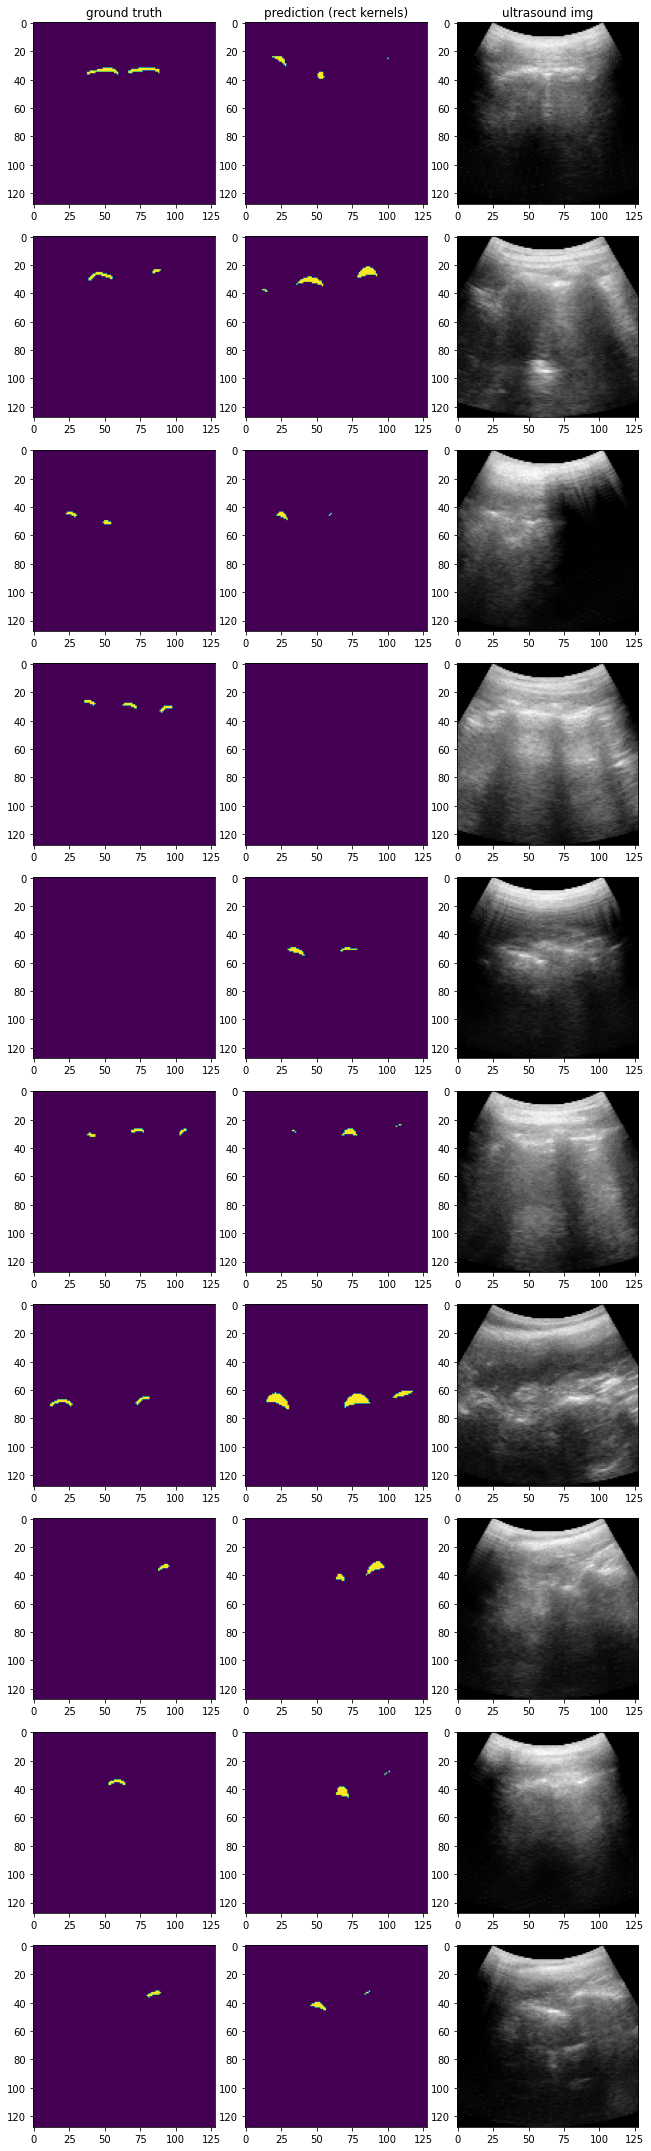

In [30]:
# View some segmentations

# print(test_segmentation_array.size())
# print(test_ultrasound_array.size())
# print(test_prediction.size())

num_rows = 10
np.random.seed(1)
indices = test_prediction.size(0)*np.random.rand(num_rows)

fig, axs = plt.subplots(num_rows,3)
fig.set_size_inches(9,3*num_rows)

for i in range(num_rows):
    idx = int(indices[i])
    
    img_np = test_ultrasound_array[idx].squeeze(0).detach().numpy()
    img_np = np.flip(img_np, axis=0)
    gt_np = test_segmentation_array[idx].detach().numpy()
    gt_np = np.flip(gt_np, axis=0)
    pred_sm_np = test_prediction[idx][1,:,:].squeeze(0).detach().numpy()
    pred_sm_np = pred_sm_np > 0.5
    pred_sm_np = np.flip(pred_sm_np, axis=0)
    
    axs[i,0].imshow(gt_np)
    if i == 0:
        axs[i,0].set_title("ground truth")
    axs[i,1].imshow(pred_sm_np, vmin=0., vmax=1.)
    if i == 0:
        axs[i,1].set_title("prediction (rect kernels)")
    axs[i,2].imshow(img_np, cmap='gray')
    if i == 0:
        axs[i,2].set_title("ultrasound img")

plt.tight_layout()

plt.savefig('.rectkernelpreds_threshed.png')

In [24]:
# Save results table

csv_filename = this_notebook_name + "_" + train_timestamp + ".csv"
csv_fullname = os.path.join(results_save_fullpath, csv_filename)
results_df.to_csv(csv_fullname)

print("Results saved to: {}".format(csv_fullname))

Results saved to: /home/nick/dev/SaggitalSpineSegmentation_Data/SavedResults/PyTorchSagittalSpineSegmentationTest-RectangularKernels_2021-08-05_16-21-43.csv


In [25]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [26]:
# Export HTML copy of this notebook

notebook_file_name = this_notebook_name + "_" + train_timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: /home/nick/dev/SaggitalSpineSegmentation_Data/SavedNotebooks/PyTorchSagittalSpineSegmentationTest-RectangularKernels_2021-08-05_16-21-43.html
